In [50]:
import sys
sys.path.append('../..')
import wandb
from data import load_data
from model_configs import build_model
from sklearn.linear_model import RidgeClassifier
from meco import MECO
from models import GCN, train_lens, test_lens
import os
import joblib
from scipy.io import arff
import pandas as pd
from sklearn import preprocessing
from sklearn.impute import KNNImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold
from xgboost import XGBClassifier
import torch
import torch_explain as te
from torch.nn.functional import one_hot
from torch_explain.logic.nn import entropy
from torch_explain.logic.metrics import test_explanation, complexity
from sklearn.metrics import f1_score, accuracy_score
from sklearn.model_selection import StratifiedShuffleSplit
import torch.nn as nn
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv, Sequential
from torch_geometric.utils.convert import from_networkx
from torch_geometric.utils import to_undirected, add_remaining_self_loops
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from torch.nn.functional import one_hot, leaky_relu


In [82]:
models = ['EVOLENS', 'RF', 'DT']
# models = ['RF', 'DT']

# load data
x, y, is_control = load_data(data_path='../../data/MiceProtein.arff')

sss = StratifiedShuffleSplit(n_splits=5, random_state=42)
sss.get_n_splits(x, y)
results = pd.DataFrame([], columns=['Model', 'Model Error (%)', 'Explanation Error (%)', 'Explanation Complexity (log)'])
for split, (train_index, test_index) in enumerate(sss.split(x, y)):
    if split > 1:
        break
    for model_name in models:
        model_path = os.path.join('./artifacts', str(split), model_name)
        model = joblib.load(os.path.join(model_path, "model.pkl"))
        if model_name == 'EVOLENS':
            for sol in model.optimal_solutions_:
                results.loc[len(results)] = [model_name, 1-sol['accuracy'], 1-sol['explanation_accuracy'], np.log(sol['explanation_complexity'])]
        elif model_name == 'DT':
            y_pred = model.predict(x[test_index])
            f1 = f1_score(y[test_index], y_pred, average='weighted')
            n_nodes = model.tree_.node_count
            results.loc[len(results)] = [model_name, 1-f1, 1-f1, np.log(n_nodes)]
        else:
            y_pred = model.predict(x[test_index])
            f1 = f1_score(y[test_index], y_pred, average='weighted')
            n_count = 0
            for est in model.estimators_:
                n_count += est.tree_.node_count
            results.loc[len(results)] = [model_name, 1-f1, 1-f1, np.log(n_count)]

In [55]:
results

,Model,Model Error (%),Explanation Error (%),Explanation Complexity
0,EVOLENS,0.390247,0.328410,1.252763
1,EVOLENS,0.306063,0.297876,1.252763
2,EVOLENS,0.806722,0.343983,1.252763
3,EVOLENS,0.510507,0.365440,1.098612
4,EVOLENS,0.618891,0.331043,0.916291
5,RF,0.009259,0.009259,10.021981
6,DT,0.091928,0.091928,5.068904
7,EVOLENS,0.455548,0.279449,1.252763
8,EVOLENS,0.494661,0.339175,1.098612
9,EVOLENS,0.862358,0.348387,1.098612


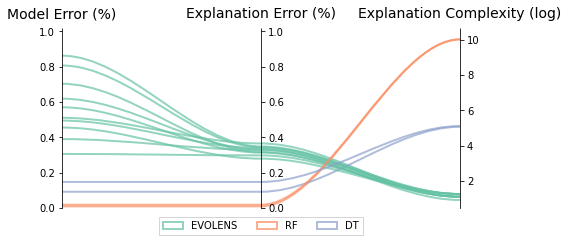

In [93]:
from matplotlib.path import Path
import matplotlib.patches as patches

result_dir = './results/figs'
os.makedirs(result_dir, exist_ok=True)

model_id = {'EVOLENS': 0, 'RF': 1, 'DT': 2}
ynames = ['Model Error (%)', 'Explanation Error (%)', 'Explanation Complexity (log)']
ys = results.values[:, 1:]
ymins = ys.min(axis=0)
ymaxs = ys.max(axis=0)
dys = ymaxs - ymins
ymins -= dys * 0.05  # add 5% padding below and above
ymaxs += dys * 0.05

# ymaxs[1], ymins[1] = ymins[1], ymaxs[1]  # reverse axis 1 to have less crossings
ymaxs[0], ymins[0] = 1, 0
ymaxs[1], ymins[1] = 1, 0
dys = ymaxs - ymins

# transform all data to be compatible with the main axis
zs = np.zeros_like(ys)
zs[:, 0] = ys[:, 0]
zs[:, 1:] = (ys[:, 1:] - ymins[1:]) / dys[1:] * dys[0] + ymins[0]

fig, host = plt.subplots(figsize=(8,3.5))

axes = [host] + [host.twinx() for i in range(ys.shape[1] - 1)]
for i, ax in enumerate(axes):
    ax.set_ylim(ymins[i], ymaxs[i])
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    if ax != host:
        ax.spines['left'].set_visible(False)
        ax.yaxis.set_ticks_position('right')
        ax.spines["right"].set_position(("axes", i / (ys.shape[1] - 1)))

host.set_xlim(0, ys.shape[1] - 1)
host.set_xticks(range(ys.shape[1]))
host.set_xticklabels(ynames, fontsize=14)
host.tick_params(axis='x', which='major', pad=7)
host.spines['right'].set_visible(False)
host.xaxis.tick_top()
# host.set_title('Parallel Coordinates Plot — Iris', fontsize=18, pad=12)

colors = plt.cm.Set2.colors
model_ids = [model_id[i] for i in results['Model'].values]
legend_handles = [None for _ in model_ids]
for j in range(ys.shape[0]):
    # create bezier curves
    verts = list(zip([x for x in np.linspace(0, len(ys) - 1, len(ys) * 3 - 2, endpoint=True)],
                     np.repeat(zs[j, :], 3)[1:-1]))
    codes = [Path.MOVETO] + [Path.CURVE4 for _ in range(len(verts) - 1)]
    path = Path(verts, codes)
    patch = patches.PathPatch(path, facecolor='none', lw=2, alpha=0.7, edgecolor=colors[model_ids[j]])
    legend_handles[model_ids[j]] = patch
    host.add_patch(patch)
host.legend(legend_handles, model_id.keys(),
            loc='lower center', bbox_to_anchor=(0.5, -0.18),
            ncol=len(model_id.keys()), fancybox=False, shadow=False)
plt.tight_layout()
plt.savefig(os.path.join(result_dir, 'pareto.png'), facecolor='white', transparent=False)
plt.savefig(os.path.join(result_dir, 'pareto.pdf'), facecolor='white', transparent=False)
plt.show()